## Compare VOPy with Optuna on Black-box Vector Optimization
This notebook compares VOPy with the state-of-the-art black-box optimization library called **Optuna**. As a real-world problem, we use a Paal-Knorr reaction for optimization. This problem is implemented in Tu et al, 2022. We will use a variant of PaVeBa (Karagözlü et al, 2023) algorithm for online learning (see :ref:`PaVeBaGPOnline` docs).

- Ben Tu, Axel Gandy, Nikolas Kantas, Behrang Shafei. [Joint Entropy Search for Multi-objective Bayesian Optimization](https://arxiv.org/pdf/2210.02905.pdf). NeurIPS 2022. [GitHub Repo.](https://github.com/benmltu/JES/)

Before starting, make sure the Optuna is installed. We include it as optional-dependencies under `examples`. See [pyproject.toml](pyproject.toml).

In [28]:
import warnings
from unittest import mock

import logging
from importlib import reload


import matplotlib.pyplot as plt

import torch
import numpy as np
from scipy.stats.qmc import Sobol

import optuna

from vopy.utils import set_seed
from vopy.order import ConeTheta2DOrder
from vopy.algorithms import PaVeBaGPOnline
from vopy.maximization_problem import FixedPointsProblem
from vopy.utils.evaluate import calculate_epsilonF1_score

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

reload(logging)
logging.basicConfig(level=logging.INFO)

#### Loading `PK2` from JES dynamically
The code for JES is not properly packaged, so we can not install it using pip. Therefore, we download the file we are interested in and load it manually.

In [29]:
import importlib, sys, pathlib
from urllib.request import urlopen

RAW_URL_COMMIT = "https://raw.githubusercontent.com/benmltu/JES/7ea9856781869c0cd348fb52c7431c40274225e9/jes/benchmarks/chembench.py"
cache_dir = pathlib.Path("tmp/jes/")
cache_dir.mkdir(parents=True, exist_ok=True)

try:
    with urlopen(RAW_URL_COMMIT) as resp:
        source_bytes = resp.read()
except Exception as dl_e:
    raise RuntimeError(f"Failed to download chembench.py from JES repo: {dl_e}")

cached_path = cache_dir / f"chembench.py"
if not cached_path.exists():
    cached_path.write_bytes(source_bytes)

# Load module from cached file
spec_name = f"_jes_chembench"
spec = importlib.util.spec_from_file_location(spec_name, cached_path)

module = importlib.util.module_from_spec(spec)
sys.modules[spec_name] = module

spec.loader.exec_module(module)

PK2 = getattr(module, "PK2")

Fixing a seed for reproducibility.

In [30]:
set_seed(0)

We will create a problem instance from JES module. Note that we are maximizing, hence the `negate=True`.

In [31]:
noise_var = 0.0001
noise_std = noise_var ** 0.5  # Only known by the problem.

problem = PK2(noise_std=noise_std, negate=True)

Let's now create our `Order` object to define our preference.

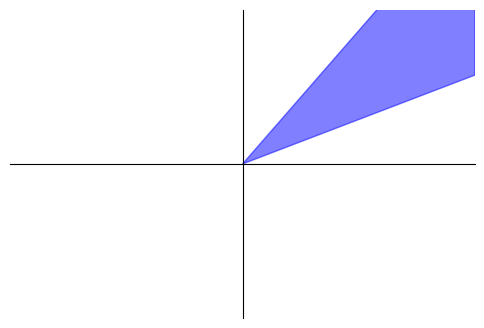

In [ ]:
order = ConeTheta2DOrder(cone_degree=30)
fig_cone = order.ordering_cone.plot()

As we will work in a fixed cardinality space, we fix the possible design choices beforehand.

In [33]:
design_count = 300

input_bounds = problem._bounds

# Create designs
num_sobol_samples = design_count
sampler = Sobol(problem.dim, scramble=False)
sampler.fast_forward(np.random.randint(low=1, high=max(2, num_sobol_samples)))
X_np = sampler.random(num_sobol_samples)

# Scale designs to the problem bounds
for i, (l, u) in enumerate(input_bounds):
    X_np[:, i] = X_np[:, i] * (u - l) + l

### Algorithms
We'll now setup and run both frameworks (VOPy and Optuna).

#### Set up and run VOPy

In [34]:
paveba_problem = FixedPointsProblem(
    in_points=X_np,
    out_dim=problem.num_objectives,
    objective=lambda x: problem(torch.tensor(x)).numpy(force=True),
)

# Algorithm parameters
epsilon = 0.01
delta = 0.05

paveba_alg = PaVeBaGPOnline(
    epsilon=epsilon,
    delta=delta,
    problem=paveba_problem,
    order=order,
    conf_contraction=128,
    initial_sample_cnt=25,
    reset_on_retrain=False,
)

while True:
    is_done = paveba_alg.run_one_step()

    if is_done:
        break

INFO:root:Training started.
INFO:root:Training done.
INFO:root:Round 1:Evaluating
INFO:root:Training started.
INFO:root:Training done.
INFO:root:Round 1:Modeling
INFO:root:Round 1:Discarding
INFO:root:Round 1:Pareto update
INFO:root:Round 1:Useful update
INFO:root:Round 1:There are 137 designs left in set S and 3 designs in set P.
INFO:root:Round 1:Sample count 26
INFO:root:Round 2:Evaluating
INFO:root:Training started.
INFO:root:Training done.
INFO:root:Round 2:Modeling
INFO:root:Round 2:Discarding
INFO:root:Round 2:Pareto update
INFO:root:Round 2:Useful update
INFO:root:Round 2:There are 131 designs left in set S and 4 designs in set P.
INFO:root:Round 2:Sample count 27
INFO:root:Round 3:Evaluating
INFO:root:Training started.
INFO:root:Training done.
INFO:root:Round 3:Modeling
INFO:root:Round 3:Discarding
INFO:root:Round 3:Pareto update
INFO:root:Round 3:Useful update
INFO:root:Round 3:There are 125 designs left in set S and 5 designs in set P.
INFO:root:Round 3:Sample count 28
INFO:

#### Set up and run Optuna

In [35]:
# def optuna_objective(trial):
#     index = trial.suggest_categorical("tau_temp_equ", list(range(len(X))))

#     inp = torch.tensor(X[index]).reshape(1, problem.dim)
#     return problem(inp).numpy(force=True).tolist()[0]

# def optuna_objective(trial):
#     index = trial.suggest_categorical("tau_temp_equ", X)

#     inp = torch.tensor(X[index]).reshape(1, problem.dim)
#     return problem(inp).numpy(force=True).tolist()[0]

def optuna_objective(trial):
    tau = trial.suggest_float("tau", problem._bounds[0][0], problem._bounds[0][1])
    temperature = trial.suggest_float("temperature", problem._bounds[1][0], problem._bounds[1][1])
    equivalents = trial.suggest_float("equivalents", problem._bounds[2][0], problem._bounds[2][1])
    suggested_point = np.array([tau, temperature, equivalents])
    # inp = torch.tensor(suggested_point).reshape(1, problem.dim)

    distances = np.linalg.norm(X_np - suggested_point, axis=1)
    closest_index = np.argmin(distances)
    inp = torch.tensor(X_np[closest_index]).reshape(1, problem.dim)
    
    return problem(inp).numpy(force=True).tolist()[0]

X = X_np.tolist()
X = [tuple(x) for x in X]

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(optuna_objective, n_trials=paveba_alg.sample_count, timeout=120)
print("Number of finished trials: ", len(study.trials))

Number of finished trials:  184


### Evaluation

We will evaluate the frameworks. We can start by computing the ground truth values.

In [37]:
Y_true = problem(torch.tensor(X_np), noise=False).numpy(force=True)

We compute the corresponding Pareto set approximations.

In [38]:
optuna_p_set = set()
for trial in study.best_trials:
    trial_pt = np.array((trial.params["tau"], trial.params["temperature"], trial.params["equivalents"]))
    closest_index = np.argmin(np.linalg.norm(trial_pt - X_np, axis=1))
    optuna_p_set.add(closest_index)
optuna_p_set = list(optuna_p_set)

vopy_p_set = list(paveba_alg.P)

Results in cone order that we defined:

In [40]:
dataset = mock.Mock()
dataset.out_data = Y_true
true_pareto_inds = order.get_pareto_set(Y_true)

vopy_epsf1 = calculate_epsilonF1_score(dataset, order, true_pareto_inds, vopy_p_set, epsilon)
optuna_epsf1 = calculate_epsilonF1_score(dataset, order, true_pareto_inds, optuna_p_set, epsilon)

print(f"VOPy epsilon-F1 score: {vopy_epsf1:.2f}")
print(f"Optuna epsilon-F1 score: {optuna_epsf1:.2f}")

VOPy epsilon-F1 score: 0.78
Optuna epsilon-F1 score: 0.30


#### Visualization of Pareto sets

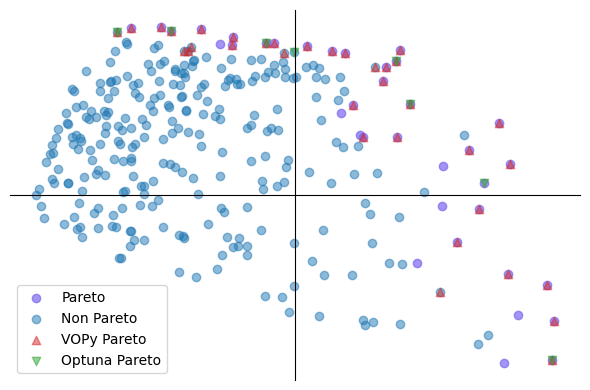

In [41]:
tmp_pareto_fig = order.plot_pareto_set(Y_true)
tmp_pareto_fig.axes[0].scatter(
    dataset.out_data[vopy_p_set][:, 0],
    dataset.out_data[vopy_p_set][:, 1],
    c="tab:red", label="VOPy Pareto", alpha=0.5, marker="^"
)
tmp_pareto_fig.axes[0].scatter(
    dataset.out_data[optuna_p_set][:, 0],
    dataset.out_data[optuna_p_set][:, 1],
    c="tab:green", label="Optuna Pareto", alpha=0.5, marker="v"
)
tmp_pareto_fig.axes[0].legend(loc="lower left")

#### END

**Check if Optuna improves over higher sample counts**

In [30]:
def optuna_objective(trial):
    tau = trial.suggest_float("tau", problem._bounds[0][0], problem._bounds[0][1])
    temperature = trial.suggest_float("temperature", problem._bounds[1][0], problem._bounds[1][1])
    equivalents = trial.suggest_float("equivalents", problem._bounds[2][0], problem._bounds[2][1])
    suggested_point = np.array([tau, temperature, equivalents])

    distances = np.linalg.norm(X_np - suggested_point, axis=1)
    closest_index = np.argmin(distances)
    
    inp = torch.tensor(X_np[closest_index]).reshape(1, problem.dim)
    return problem(inp).numpy(force=True).tolist()[0]

study = optuna.create_study(directions=["maximize", "maximize"])
for i in range(12):
    study.optimize(optuna_objective, n_trials=50, timeout=120)
    optuna_p_set = set()
    for trial in study.best_trials:
        trial_pt = np.array((trial.params["tau"], trial.params["temperature"], trial.params["equivalents"]))
        closest_index = np.argmin(np.linalg.norm(trial_pt - X_np, axis=1))
        optuna_p_set.add(closest_index)
    optuna_p_set = list(optuna_p_set)
    optuna_epsf1 = calculate_epsilonF1_score(dataset, order, true_pareto_inds, optuna_p_set, epsilon)
    optuna_epsf1_mo = calculate_epsilonF1_score(dataset, order_mo, true_pareto_inds_mo, optuna_p_set, epsilon)
    print(f"epsilon-F1 of VO and MO score at trial {(i + 1) * 50}: {optuna_epsf1:.3f}, {optuna_epsf1_mo:.3f}")

epsilon-F1 of VO and MO score at trial 50: 0.279, 0.316
epsilon-F1 of VO and MO score at trial 100: 0.391, 0.522
epsilon-F1 of VO and MO score at trial 150: 0.426, 0.500
epsilon-F1 of VO and MO score at trial 200: 0.426, 0.500
epsilon-F1 of VO and MO score at trial 250: 0.391, 0.783
epsilon-F1 of VO and MO score at trial 300: 0.391, 0.783
epsilon-F1 of VO and MO score at trial 350: 0.490, 0.769
epsilon-F1 of VO and MO score at trial 400: 0.490, 0.769
epsilon-F1 of VO and MO score at trial 450: 0.426, 0.870
epsilon-F1 of VO and MO score at trial 500: 0.426, 0.870
epsilon-F1 of VO and MO score at trial 550: 0.458, 0.880
epsilon-F1 of VO and MO score at trial 600: 0.458, 0.880


**Evaluate according to MO**

Results in componentwise (multi-objective) cone:

In [ ]:
order_mo = ConeTheta2DOrder(cone_degree=90)
fig_cone_mo = order_mo.ordering_cone.plot()

In [ ]:
true_pareto_inds_mo = order_mo.get_pareto_set(Y_true)

vopy_epsf1_mo = calculate_epsilonF1_score(dataset, order_mo, true_pareto_inds_mo, vopy_p_set, epsilon)
optuna_epsf1_mo = calculate_epsilonF1_score(dataset, order_mo, true_pareto_inds_mo, optuna_p_set, epsilon)

print("VOPy epsilon-F1 score:", vopy_epsf1_mo)
print("Optuna epsilon-F1 score:", optuna_epsf1_mo)

**Optuna Pareto set is unrestricted.**

In [ ]:
X_optuna = [[trial.params["tau"], trial.params["temperature"], trial.params["equivalents"]] for trial in study.best_trials]
X_optuna = np.array(X_optuna)
Y_true_optuna = problem(torch.tensor(X_optuna), noise=False).numpy(force=True)

Y_true_vopy = Y_true[list(paveba_alg.P)]
Y_true_pareto = Y_true[order.get_pareto_set(Y_true)]

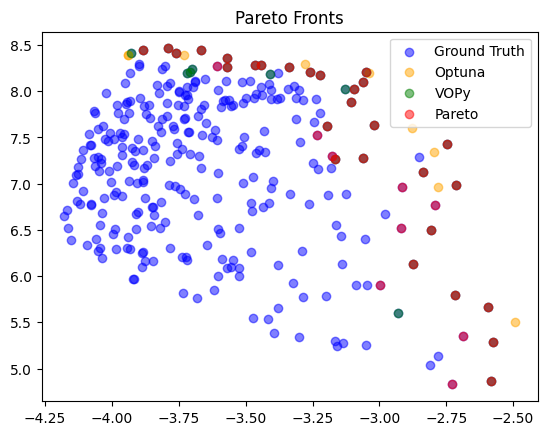

In [ ]:
plt.scatter(Y_true[:, 0], Y_true[:, 1], label="Ground Truth", alpha=0.5, c='blue')
plt.scatter(Y_true_optuna[:, 0], Y_true_optuna[:, 1], label="Optuna", alpha=0.5, c='orange')
plt.scatter(Y_true_vopy[:, 0], Y_true_vopy[:, 1], label="VOPy", alpha=0.5, c='green')
plt.scatter(Y_true_pareto[:, 0], Y_true_pareto[:, 1], label="Pareto", alpha=0.5, c='red')

plt.title("Pareto Fronts")
plt.legend()
plt.show()